# Homework 5: Natural Language Processing

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

In [434]:
MY_UNIQNAME = 'tabbie'

## Scenario

As a newly hired member of the United Nation's (UN) Archives and Records Management Section (ARMS), your manager has asked you to analyze forty years of statements presented by hundreds of heads of state and senior officials at the UN General Debates. Your initial report should clearly document the steps you have taken to manipulate the data as well as insights from trends and patterns you identify which your manager may want to share with her peers within the UN. 

## 0. Download the data from: 

* [https://www.kaggle.com/unitednations/un-general-debates](https://www.kaggle.com/unitednations/un-general-debates)

In [435]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from collections import Counter
import nltk

### <span style="color:magenta"> Q1. [10 pts] Initial clean up and EDA
1. Load the UN General Debates data.
1. Merge in the ISO 3166 country names available here: https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes.
1. Clean and simplify the country names by removing any values between parentheses () or brackets [].
1. Report the mean number of statements delivered by a country.
1. Report the five countries that have delivered the fewest statements in total.

In [436]:
#UN General Debates data loaded
un_debates = pd.read_csv('un-general-debates.csv')
un_debates.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [437]:
#Loading the data from wikipedia and cleaning the column names 
wiki_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes', header=1)
wiki = wiki_df[0]
wiki.columns = wiki.columns.str.strip().str.lower().str.replace(' ','_')
wiki.columns = wiki.columns.str.strip().str.replace('\[([0-9]+)\]', '')
wiki.head()

,country_name,official_state_name,sovereignty,alpha-2_code,alpha-3_code,numeric_code,subdivision_code_links,internet_cctld
0,Afghanistan,The Islamic Republic of Afghanistan,UN member state,.mw-parser-output .monospaced{font-family:mono...,AFG,004,ISO 3166-2:AF,.af
1,"Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The"
2,Åland Islands,Åland,Finland,AX,ALA,248,ISO 3166-2:AX,.ax
3,Albania,The Republic of Albania,UN member state,AL,ALB,008,ISO 3166-2:AL,.al
4,Algeria,The People's Democratic Republic of Algeria,UN member state,DZ,DZA,012,ISO 3166-2:DZ,.dz


In [438]:
wiki_ = wiki[['country_name', 'alpha-3_code']]
wiki_

,country_name,alpha-3_code
0,Afghanistan,AFG
1,"Akrotiri and Dhekelia – See United Kingdom, The","Akrotiri and Dhekelia – See United Kingdom, The"
2,Åland Islands,ALA
3,Albania,ALB
4,Algeria,DZA
...,...,...
275,Wallis and Futuna,WLF
276,Western Sahara [ah],ESH
277,Yemen,YEM
278,Zambia,ZMB


In [439]:
#Merging the the two datas
df_final = un_debates.merge(wiki_, how = "left", left_on= "country", right_on="alpha-3_code")
df_final

,session,year,country,text,country_name,alpha-3_code
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,Maldives,MDV
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",Finland,FIN
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",Niger (the),NER
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,Uruguay,URY
4,44,1989,ZWE,﻿I should like at the outset to express my del...,Zimbabwe,ZWE
...,...,...,...,...,...,...
7502,56,2001,KAZ,﻿This session\nthat is taking place under extr...,Kazakhstan,KAZ
7503,56,2001,LBR,﻿I am honoured to\nparticipate in this histori...,Liberia,LBR
7504,56,2001,BDI,﻿It\nis for me a signal honour to take the flo...,Burundi,BDI
7505,56,2001,HUN,"﻿First, may I congratulate Mr. Han Seung-soo o...",Hungary,HUN


In [440]:
#Cleaning the country column part 1
df_clean1 = df_final.country_name.str.replace('\[.*?\]', '').to_frame()
df_clean1

,country_name
0,Maldives
1,Finland
2,Niger (the)
3,Uruguay
4,Zimbabwe
...,...
7502,Kazakhstan
7503,Liberia
7504,Burundi
7505,Hungary


In [441]:
#Cleaning the country column part 2
df_clean = df_clean1.country_name.str.replace('\(.*\)', '').to_frame()
df_clean

,country_name
0,Maldives
1,Finland
2,Niger
3,Uruguay
4,Zimbabwe
...,...
7502,Kazakhstan
7503,Liberia
7504,Burundi
7505,Hungary


In [442]:
df_temp = df_final.copy()

In [443]:
#deleting the unclean column
del df_temp['country_name']

In [444]:
#joining the cleaned data with the cleaned column
df_finale = df_temp.join(df_clean)
df_finale

,session,year,country,text,alpha-3_code,country_name
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,MDV,Maldives
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",FIN,Finland
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",NER,Niger
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,URY,Uruguay
4,44,1989,ZWE,﻿I should like at the outset to express my del...,ZWE,Zimbabwe
...,...,...,...,...,...,...
7502,56,2001,KAZ,﻿This session\nthat is taking place under extr...,KAZ,Kazakhstan
7503,56,2001,LBR,﻿I am honoured to\nparticipate in this histori...,LBR,Liberia
7504,56,2001,BDI,﻿It\nis for me a signal honour to take the flo...,BDI,Burundi
7505,56,2001,HUN,"﻿First, may I congratulate Mr. Han Seung-soo o...",HUN,Hungary


In [445]:
#Number of statements delivered by countries
df_finale.groupby('country_name').text.count().mean()

38.373056994818654

The mean of the total number of statements delivered by all the countries is 38.73.

In [446]:
#checking if the obtained dataframe is correct
each_country_stats = df_finale.groupby('country_name').text.count().sort_values(ascending = False).to_frame()
each_country_stats

,text
country_name,
Korea,50
Congo,46
Colombia,46
Japan,46
Sudan,46
...,...
Timor-Leste,13
Kiribati,13
Holy See,13


The total number of statements delivered by each country is represented by "each_country_stats" which shows that Korea has the maximum number of statements i.e; 50 and South Sudan has least number of statements i.e; 5.

In [447]:
# The five countries that have delivered the fewest statements in total
df_finale_ = df_finale.groupby('country_name').text.count().sort_values(ascending = True).to_frame()
df_finale_.head(5)

,text
country_name,
South Sudan,5
Montenegro,10
Holy See,13
Kiribati,13
Timor-Leste,13


The countries that have delivered fewest statements are represented by the variable "df_finale_". They are as follows:
1. South Sudan = 5 statements
2. Montenegro = 10 statements
3. Holy See = 13 statements
4. Kiribati = 13 statements
5. Timor-Leste = 13 statements

### <span style="color:magenta"> Q2. [15 pts] Search with regex
1. Select the text of three different statements.
1. Pick one of the texts and find the count of how many times terms like cooperation, cooperate, cooperating, cooperated, cooperates are in the text.
1. Pick another one of the texts and find the count of how many times terms like democracy, democratic, democracies, democratically, nondemocratic, and undemocratic are in the text.
1. Use the remaining text to find the count of how many times numbers or words about numbers are in the text. For instance, 1, first, one, 1st, etc. 
   - This is challenging and we don't expect you to find every single instance. Try your best at finding as many as possible but your solution must cover some combination of numbers and words referring to numbers.

In [448]:
text1 = df_final.text.iloc[0]
text1

"\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and experience. I am fully confident that under his able and wise leadership the Assembly will further consolidate the gains achieved during the past year.\nMy delegation associates itself with previous speakers in expressing its appreciation of the dedicated efforts of his predecessor, His Excellency Mr. Dante Caputo, for the exemplary manner in which he discharged his duties as President of the forty-third session of the General Assembly.\nAs in previous years, my delegation wishes to note its satisfaction with and gratitude for the assiduous and unrelenting efforts exerted by the Secretary-General of the United Nations in the cause of peace and international harmony. We pay a tribute to

In [449]:
text2 = df_final.text.iloc[4]
text2

"\ufeffI should like at the outset to express my delegation's satisfaction and pleasure at your election, Sir, to the presidency of the General Assembly at its forty-fourth session. The unanimity of that decision reflects not only your own distinguished record as Foreign Minister and Permanent Representative of your country to the United Nations but also the prestige of your country, Nigeria, of which all of us in Africa are proud.\nThe outgoing President of the General Assembly, Mr. Dante Caputo of Argentina, shouldered the responsibility of his office with distinction in a momentous and difficult year. We wish to acknowledge our debt to him.\nOur Secretary-General, Mr. Javier Perez de Cuellar, has been at the head of our Organization during some of its roost troubled and also some of its most productive and successful years. The turnaround in the fortunes of the United Nations during his watch owes much to the skill of the helmsman and we want to reassure him of our continued confide

In [450]:
text3 = df_final.text.iloc[8]
text3

"\ufeff\nPermit me to begin by warmly congratulating you. Sir on your election to the presidency of the current session of the General Assembly: I am sure that this session will be a success. I also wish to take this opportunity to express my sincere thanks to the President of the last session, Mr. Dante Caputo. For his outstanding contribution in fulfilling his high mission.\nThe past year has been marked by fresh achievements in the efforts of various countries to seek solutions to regional conflicts, reduce the threat of war and improve the international situation, and by new prospects for world peace. However, ours is not a trouble-free world. regional conflicts have not yet come to a halt. The arms race is still going on. Certain international contradictions have sharpened, owing to violation of the established norms of international law. The economic situation in the developing countries is further deteriorating. All this demonstrates that the source of world turbulence and tensi

In [451]:
#the count of how many times terms like cooperation, cooperate, cooperating, cooperated, cooperates are in the text.
len(re.findall('co-?operat[a-z]+',text1))

1

The number of times the terms like cooperation, cooperate, cooperating, cooperated and cooperates are seen in text1 is one.

In [452]:
#the count of how many times terms like democracy, democratic, democracies, democratically, nondemocratic, and undemocratic are in the text.
len(re.findall('[a-z]*democra[a-z]*',text2))

2

The number of times terms like democracy, democratic, democracies, democratically, nondemocratic, and undemocratic are in the text is 2.

In [453]:
#the count of how many times numbers or words about numbers are in the text. For instance, 1, first, one, 1st, etc.
len(re.findall('(\d+\w+\w)|(\d)|one|two|four|six|eight|nine|first|second|third|([a-z]*th)|([a-z]*en)|([a-z]*ve)|([a-z]*ee)',text3.lower()))

1050

The count of how many times numbers or words about numbers are in the third text that I chose is 1050.

### <span style="color:magenta"> Q3a. [20 pts] Tokenize and plot top 10 words  
1. Select three countries that have delivered statements for the majority of the years covered by the data.
1. Tokenize their texts and plot the ten most common words used based on the count for each country (without removing stop words, punctuation, etc.). Make sure your plots are labeled and have a title. Describe the commonalities or differences you notice.

> #### You can use nltk and/or spaCy to answer this question.

In [454]:
# The five countries that have delivered the most statements in maximum number of years
df_finale_ = df_finale.groupby('country_name').text.count().sort_values(ascending = False).to_frame()
df_finale_.head(10)

,text
country_name,
Korea,50
Congo,46
Colombia,46
Japan,46
Sudan,46
Sri Lanka,46
Brazil,46
Guatemala,46
Ghana,46


In [455]:
df_finalc = df_finale.copy()

The countries that I chose which seemed to have delivered maximum number of statements for the majority of years are Japan, Colombia and Brazil.

In [456]:
df_japan = df_finalc[df_finalc.country_name == 'Japan']
df_japan.head()

,session,year,country,text,alpha-3_code,country_name
33,44,1989,JPN,"﻿\nI should like first, on behalf of the Gover...",JPN,Japan
154,25,1970,JPN,"\n53. Mr. President, on behalf of the Japanese...",JPN,Japan
339,68,2013,JPN,"First, I would like to \ncongratulate you, Sir...",JPN,Japan
480,40,1985,JPN,On behalf of the Government and people of Japa...,JPN,Japan
733,63,2008,JPN,It is my great honour to stand \nhere as the n...,JPN,Japan


In [457]:
# for Q3b
df_japanc = df_japan.copy()

In [458]:
df_japan['text'] = df_japan.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_japan.head()

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,session,year,country,text,alpha-3_code,country_name
33,44,1989,JPN,"[﻿, I, should, like, first, ,, on, behalf, of,...",JPN,Japan
154,25,1970,JPN,"[53, ., Mr., President, ,, on, behalf, of, the...",JPN,Japan
339,68,2013,JPN,"[First, ,, I, would, like, to, congratulate, y...",JPN,Japan
480,40,1985,JPN,"[On, behalf, of, the, Government, and, people,...",JPN,Japan
733,63,2008,JPN,"[It, is, my, great, honour, to, stand, here, a...",JPN,Japan


In [459]:
# saving all the statement tokens as one big list
for j in df_japan['text']:
    japan_tokens = j

In [460]:
Counter(japan_tokens).most_common(20)

[('the', 77),
 ('to', 57),
 ('and', 47),
 (',', 46),
 ('of', 39),
 ('.', 38),
 ('in', 20),
 ('for', 17),
 ('Japan', 17),
 ('is', 17),
 ('terrorism', 15),
 ('international', 14),
 ('that', 13),
 ('United', 12),
 ('a', 11),
 ('this', 10),
 ('on', 9),
 ('community', 9),
 ('Nations', 8),
 ('with', 8)]

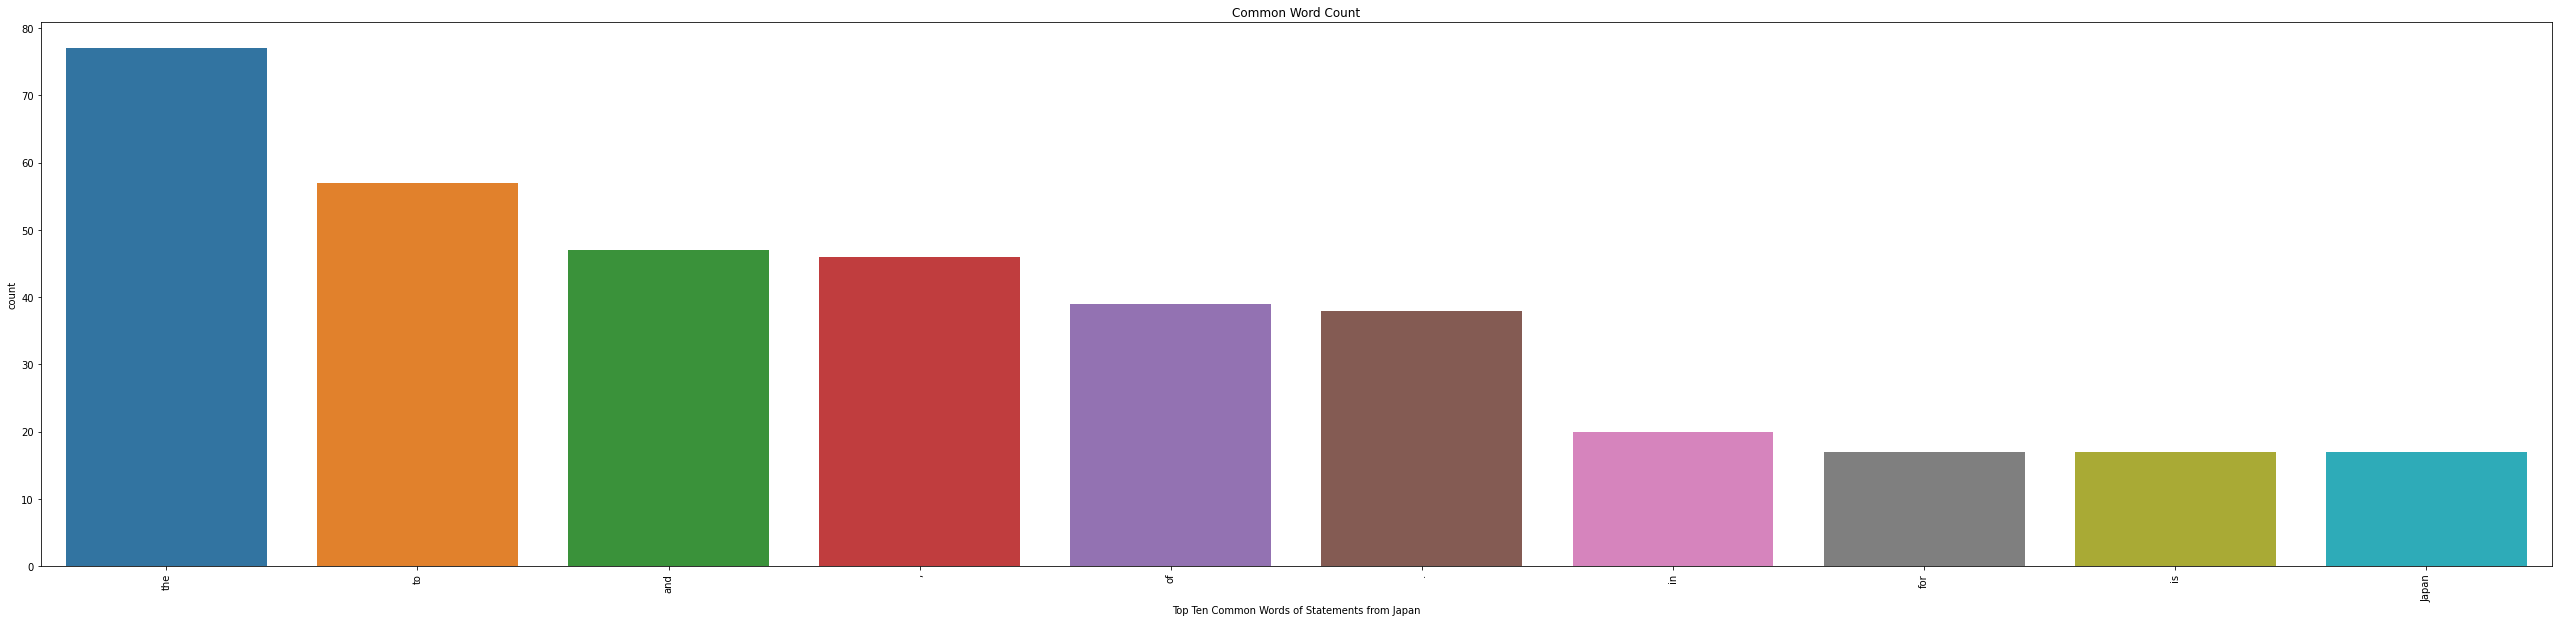

In [461]:
plt.figure(figsize=(45,10))
sns.countplot(japan_tokens, order=pd.Series(japan_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Japan')
plt.title('Common Word Count')
plt.show()

In [462]:
df_colombia = df_finalc[df_finalc.country_name == 'Colombia']
df_colombia.head()

,session,year,country,text,alpha-3_code,country_name
16,44,1989,COL,﻿\nOn behalf of the people and the Government ...,COL,Colombia
163,25,1970,COL,"Mr. President, this visit to the United Nation...",COL,Colombia
415,68,2013,COL,I \nshould like to depart slightly from protoc...,COL,Colombia
456,40,1985,COL,At the outset allow me to express Colombia's g...,COL,Colombia
579,63,2008,COL,Speaking once again before the General Assembl...,COL,Colombia


In [463]:
# for Q3b
df_colombiac = df_colombia.copy()

In [464]:
df_colombia ['text'] = df_colombia.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_colombia.head()

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,session,year,country,text,alpha-3_code,country_name
16,44,1989,COL,"[﻿, On, behalf, of, the, people, and, the, Gov...",COL,Colombia
163,25,1970,COL,"[Mr., President, ,, this, visit, to, the, Unit...",COL,Colombia
415,68,2013,COL,"[I, should, like, to, depart, slightly, from, ...",COL,Colombia
456,40,1985,COL,"[At, the, outset, allow, me, to, express, Colo...",COL,Colombia
579,63,2008,COL,"[Speaking, once, again, before, the, General, ...",COL,Colombia


In [465]:
# saving all the statement tokens as one big list
for c in df_colombia['text']:
    colombia_tokens = c

In [466]:
Counter(colombia_tokens).most_common(20)

[('the', 140),
 (',', 100),
 ('.', 99),
 ('of', 95),
 ('and', 70),
 ('to', 57),
 ('that', 48),
 ('we', 37),
 ('a', 31),
 ('in', 30),
 ('is', 28),
 ('must', 21),
 ('all', 21),
 ('our', 20),
 ('for', 20),
 ('I', 18),
 ('with', 17),
 ('world', 16),
 ('not', 16),
 ('it', 15)]

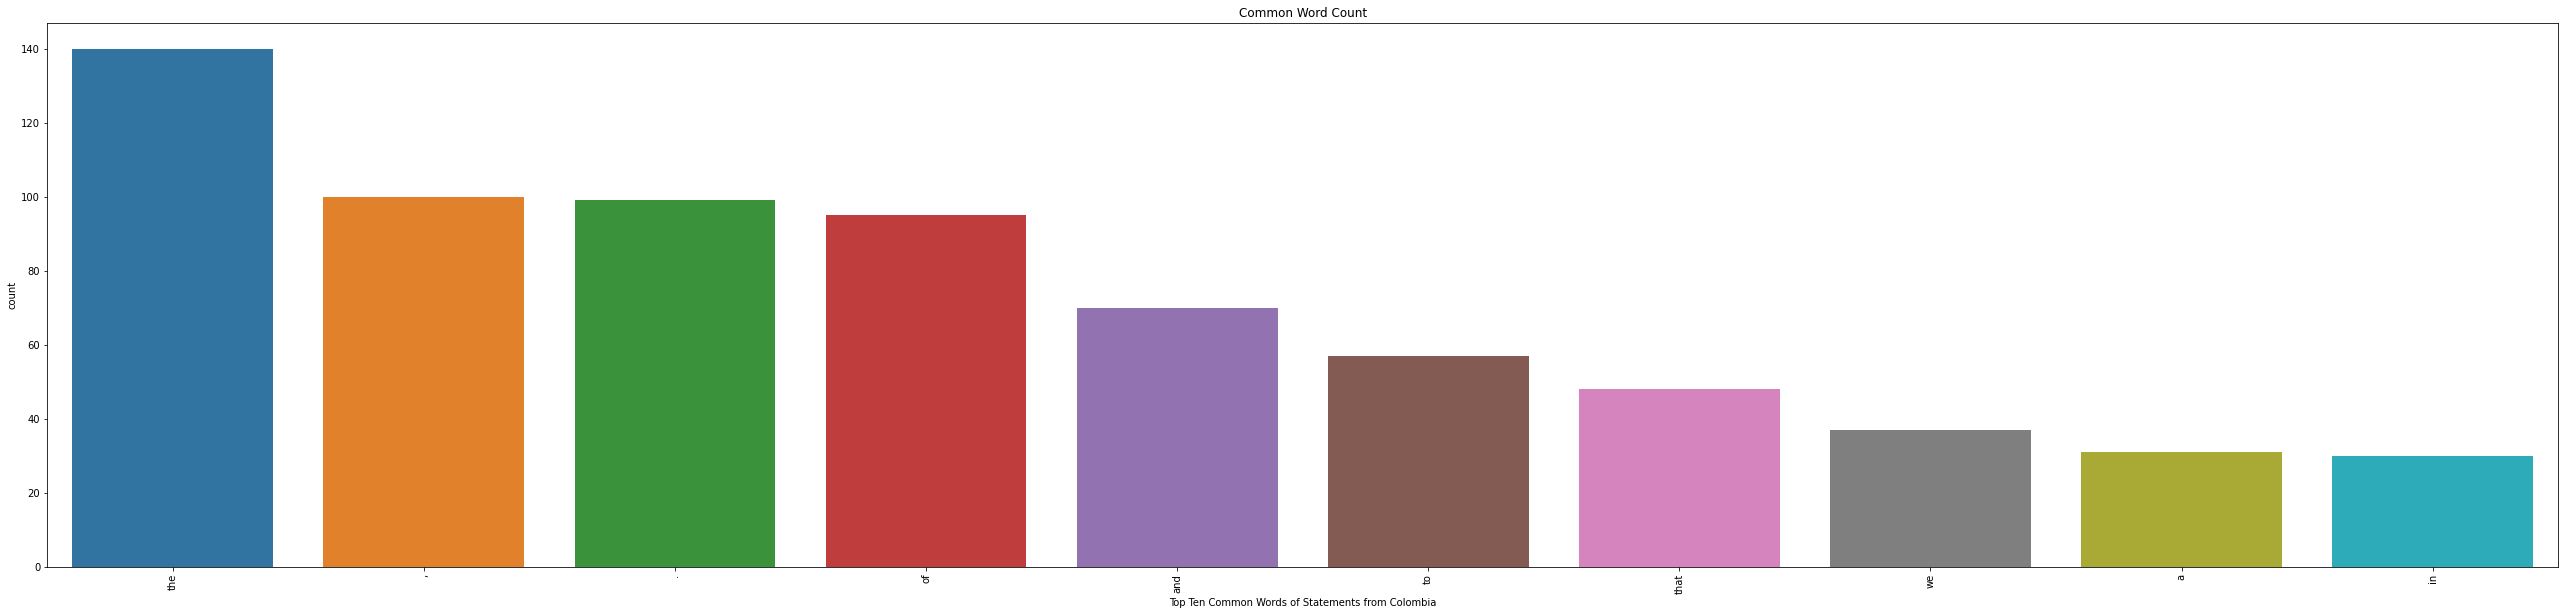

In [467]:
plt.figure(figsize=(45,10))
sns.countplot(colombia_tokens, order=pd.Series(colombia_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Colombia')
plt.title('Common Word Count')
plt.show()

In [468]:
df_brazil = df_finalc[df_finalc.country_name == 'Brazil']
df_brazil.head()

,session,year,country,text,alpha-3_code,country_name
114,44,1989,BRA,"﻿\n\nMr. President, allow me to congratulate Y...",BRA,Brazil
194,25,1970,BRA,"1.\tMr. President, I should like, first of all...",BRA,Brazil
396,68,2013,BRA,I would first like to \nbriefly express my ple...,BRA,Brazil
457,40,1985,BRA,I still have before my eyes the suffering that...,BRA,Brazil
695,63,2008,BRA,It is my great \npleasure to greet my dear fri...,BRA,Brazil


In [469]:
# for Q3b
df_brazilc = df_brazil.copy()

In [470]:
df_brazil ['text'] = df_brazil.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_brazil.head()

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,session,year,country,text,alpha-3_code,country_name
114,44,1989,BRA,"[﻿, Mr., President, ,, allow, me, to, congratu...",BRA,Brazil
194,25,1970,BRA,"[1, ., Mr., President, ,, I, should, like, ,, ...",BRA,Brazil
396,68,2013,BRA,"[I, would, first, like, to, briefly, express, ...",BRA,Brazil
457,40,1985,BRA,"[I, still, have, before, my, eyes, the, suffer...",BRA,Brazil
695,63,2008,BRA,"[It, is, my, great, pleasure, to, greet, my, d...",BRA,Brazil


In [471]:
# saving all the statement tokens as one big list
for b in df_brazil['text']:
    brazil_tokens = b

In [472]:
Counter(brazil_tokens).most_common(20)

[('the', 150),
 ('of', 118),
 (',', 99),
 ('.', 97),
 ('to', 75),
 ('and', 60),
 ('in', 46),
 ('a', 45),
 ('is', 37),
 ('that', 34),
 ('be', 32),
 ('not', 24),
 ('for', 21),
 ('The', 18),
 ('by', 16),
 ('as', 16),
 ('on', 14),
 ('will', 14),
 ('must', 14),
 ('an', 12)]

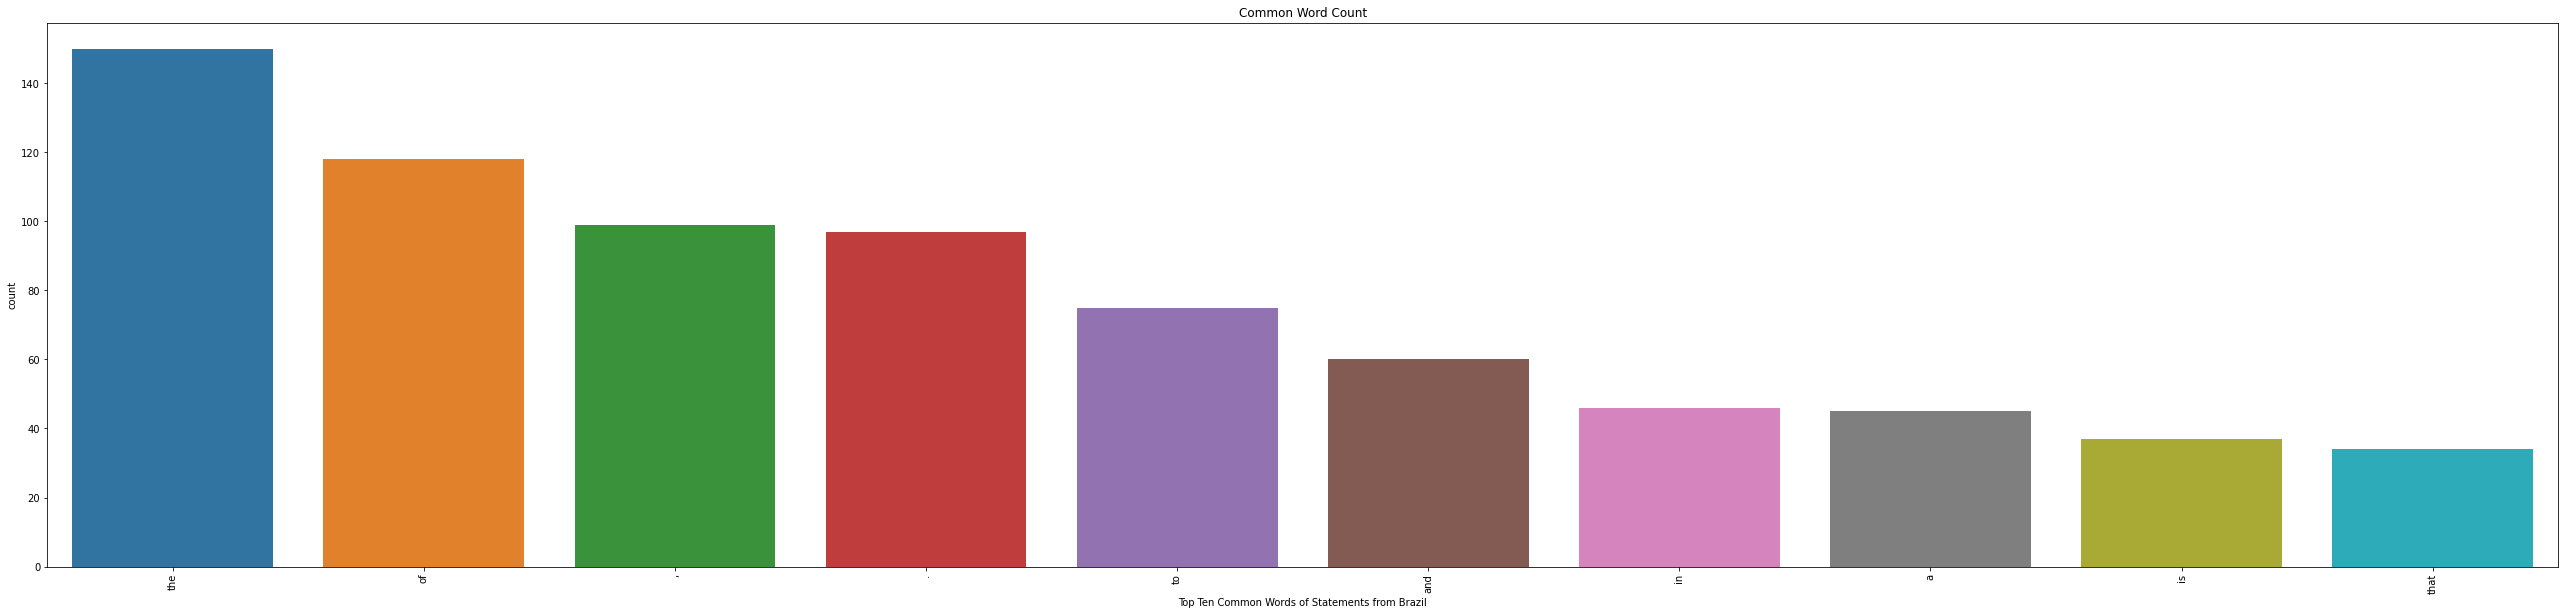

In [473]:
plt.figure(figsize=(45,10))
sns.countplot(brazil_tokens, order=pd.Series(brazil_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Brazil')
plt.title('Common Word Count')
plt.show()

From the plots above, it can be analysed that the summary texts from the countries Japan, Colombia and Brazil have the list of stopwords also commonly called as helping verbs/adverbs and punctuations in common and are often repeated. The helping verb "the" is repeated majority of times in all the texts from Japan, Colombia and Brazil whereas the word "Japan" from Japan's texts, "in" from Colombia's texts and "that" from Brazil's texts are lowest among the top 20 most commonly repeated words.

### <span style="color:magenta"> Q3b. [15 pts] Tokenize and plot top 10 words
Continue working with the same countries and their texts as selected above.
1. Remove stop words, punctuations, and any other characters you deem necessary from the tokenized text.
1. Remove a few additional words that are less informative given the context and because they are common across statements (e.g. 3 or 4 of the common words seen in the plots from 3a).
1. Plot the ten most common words used by each country. Make sure your plots are labeled and have a title. Describe any commonalities or differences you notice either between countries or with and without the words we removed.

> #### You can use nltk and/or spaCy to answer this question.

In [474]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [475]:
additional = ['world', 'international', 'community', 'may', 'must']

The variable "additional" represents the additional words that have been most commonly repeated in the texts from the countries Japan, Colombia and Brazil.

In [476]:
# referred https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
def no_stop_words(text): 
    stop = set(stopwords.words('english'))
    additional = ['world', 'international', 'community', 'may', 'must']
    meaningful_words = []
    for word in text:
        if word.lower() not in stop and additional:
            meaningful_words.append(word)
    return meaningful_words

In [477]:
df_japanc['text'] = df_japanc['text'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')

In [478]:
df_japanc ['text'] = df_japanc.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_japanc.head()

,session,year,country,text,alpha-3_code,country_name
33,44,1989,JPN,"[﻿, i, should, like, first, on, behalf, of, th...",JPN,Japan
154,25,1970,JPN,"[mr, president, on, behalf, of, the, japanese,...",JPN,Japan
339,68,2013,JPN,"[first, i, would, like, to, congratulate, you,...",JPN,Japan
480,40,1985,JPN,"[on, behalf, of, the, government, and, people,...",JPN,Japan
733,63,2008,JPN,"[it, is, my, great, honour, to, stand, here, a...",JPN,Japan


In [479]:
df_japanc['text'] = df_japanc.apply(lambda y: no_stop_words(y['text']), axis=1)
df_japanc['text']

33      [﻿, like, first, behalf, government, people, j...
154     [mr, president, behalf, japanese, delegation, ...
339     [first, would, like, congratulate, sir, assumi...
480     [behalf, government, people, japan, like, exte...
733     [great, honour, stand, new, japanese, prime, m...
811     [﻿i, like, first, extend, heartfelt, congratul...
928     [like, first, behalf, government, people, japa...
1105    [﻿first, would, like, congratulate, mr, jan, k...
1345    [major, powers, emergence, scores, new, indepe...
1480    [﻿i, like, first, extend, warmest, compliments...
1551    [﻿first, would, like, express, sincere, apprec...
1868    [﻿i, like, outset, extend, warmest, compliment...
2054    [﻿, behalf, government, japan, like, first, co...
2187    [﻿i, like, first, express, sincere, congratula...
2307    [extend, heartfelt, congratulations, mr, josep...
2485    [﻿on, behalf, government, people, japan, wish,...
2604    [like, behalf, government, japan, begin, state...
2876    [like,

In [480]:
for j in df_japanc['text']:
    clean_japan_tokens = j

In [481]:
Counter(clean_japan_tokens).most_common(20)

[('japan', 17),
 ('international', 16),
 ('terrorism', 16),
 ('united', 12),
 ('nations', 8),
 ('community', 8),
 ('afghanistan', 8),
 ('eliminate', 7),
 ('peace', 6),
 ('countries', 6),
 ('would', 5),
 ('like', 5),
 ('terrorist', 5),
 ('attacks', 5),
 ('states', 5),
 ('convention', 5),
 ('weapons', 5),
 ('extend', 4),
 ('support', 4),
 ('also', 4)]

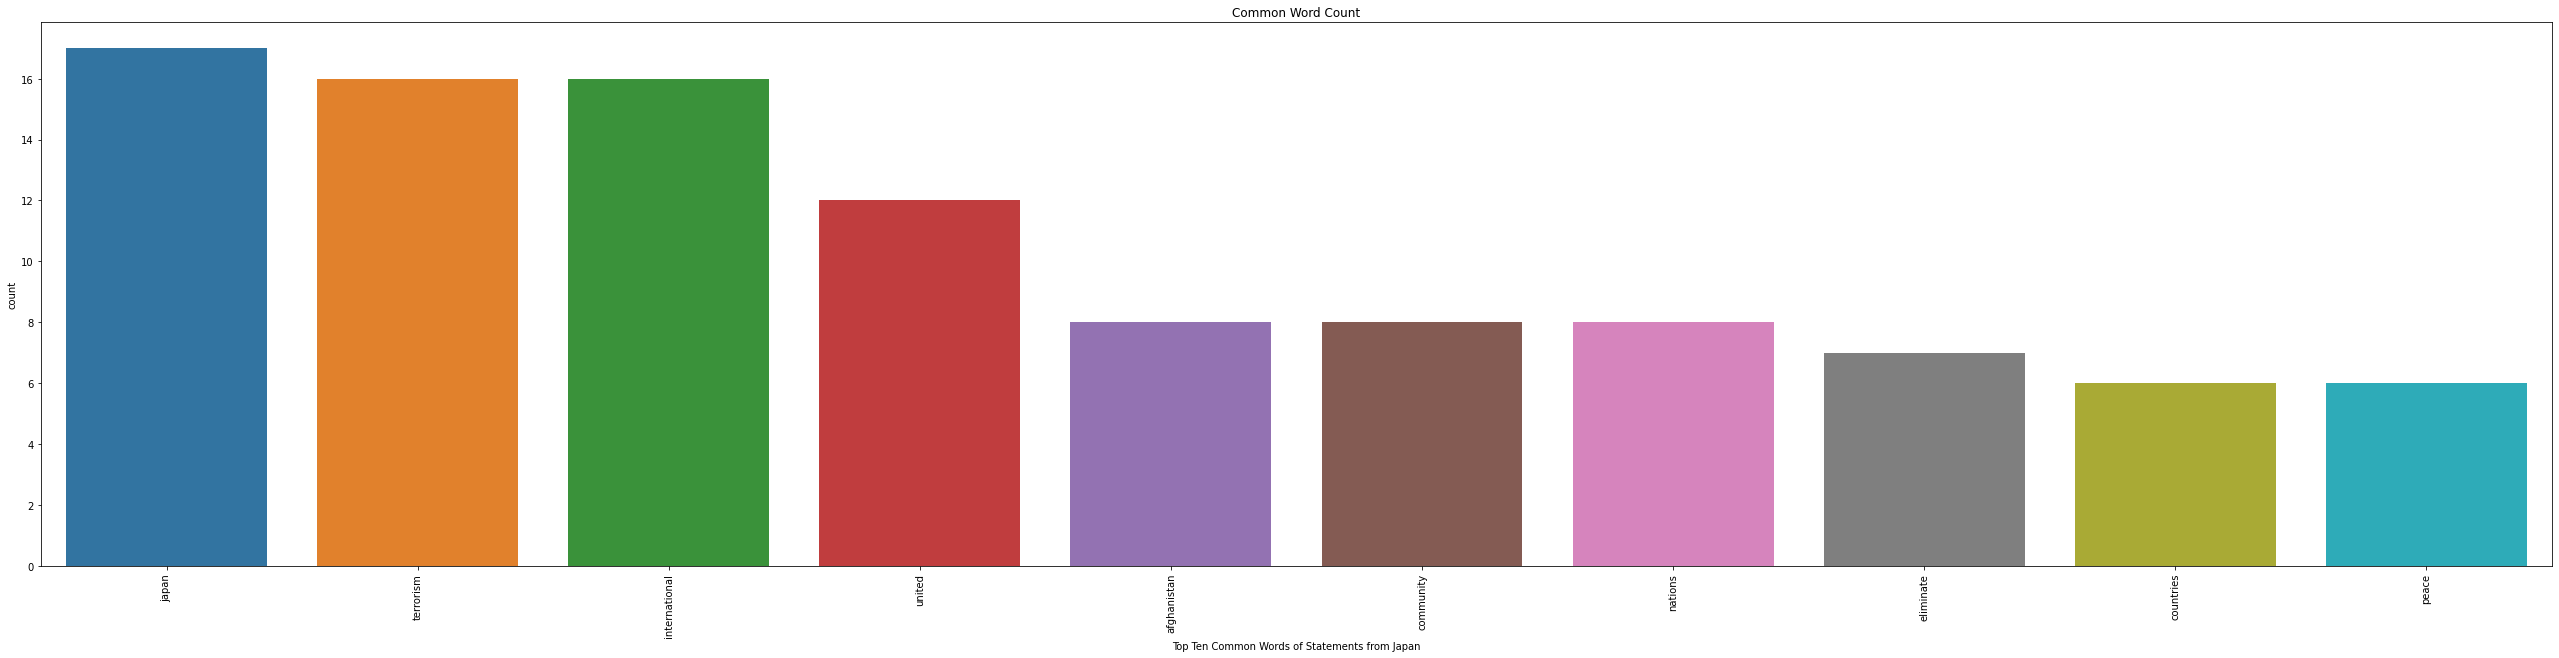

In [482]:
plt.figure(figsize=(45,10))
sns.countplot(clean_japan_tokens, order=pd.Series(clean_japan_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Japan')
plt.title('Common Word Count')
plt.show()

In [483]:
df_colombiac['text'] = df_colombiac['text'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')

In [484]:
df_colombiac['text'] = df_colombiac.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_colombiac.head()

,session,year,country,text,alpha-3_code,country_name
16,44,1989,COL,"[﻿, on, behalf, of, the, people, and, the, gov...",COL,Colombia
163,25,1970,COL,"[mr, president, this, visit, to, the, united, ...",COL,Colombia
415,68,2013,COL,"[i, should, like, to, depart, slightly, from, ...",COL,Colombia
456,40,1985,COL,"[at, the, outset, allow, me, to, express, colo...",COL,Colombia
579,63,2008,COL,"[speaking, once, again, before, the, general, ...",COL,Colombia


In [485]:
df_colombiac['text'] = df_colombiac.apply(lambda y: no_stop_words(y['text']), axis=1)
df_colombiac['text']

16      [﻿, behalf, people, government, colombia, plea...
163     [mr, president, visit, united, nations, provid...
415     [like, depart, slightly, protocol, start, stat...
456     [outset, allow, express, colombias, grief, tra...
579     [speaking, general, assembly, would, like, con...
848     [﻿in, name, people, government, colombia, allo...
1008    [first, wish, convey, greetings, congratulatio...
1070    [﻿i, greet, excellency, mr, jan, kavan, czech,...
1277    [genuinely, pleased, applaud, wisdom, shown, g...
1529    [﻿allow, outset, sir, congratulate, election, ...
1679    [﻿two, years, ago, first, address, assembly, p...
1856    [﻿as, president, colombia, chairman, non-align...
1936    [﻿, mr, president, especially, gratifying, cou...
2174    [﻿allow, first, behalf, people, government, co...
2268    [reverence, immense, sense, responsibility, co...
2498    [﻿it, good, omen, indeed, colombia, pleased, d...
2630    [behalf, government, congratulate, mr, freitas...
2843    [would

In [486]:
for c in df_colombiac['text']:
    clean_colombia_tokens = c

In [487]:
Counter(clean_colombia_tokens).most_common(20)

[('must', 21),
 ('world', 17),
 ('international', 14),
 ('colombia', 13),
 ('terrorism', 11),
 ('us', 10),
 ('country', 9),
 ('assembly', 8),
 ('acts', 8),
 ('human', 8),
 ('—', 8),
 ('illegal', 8),
 ('general', 7),
 ('let', 7),
 ('peace', 7),
 ('violence', 7),
 ('financial', 7),
 ('community', 7),
 ('new', 6),
 ('today', 6)]

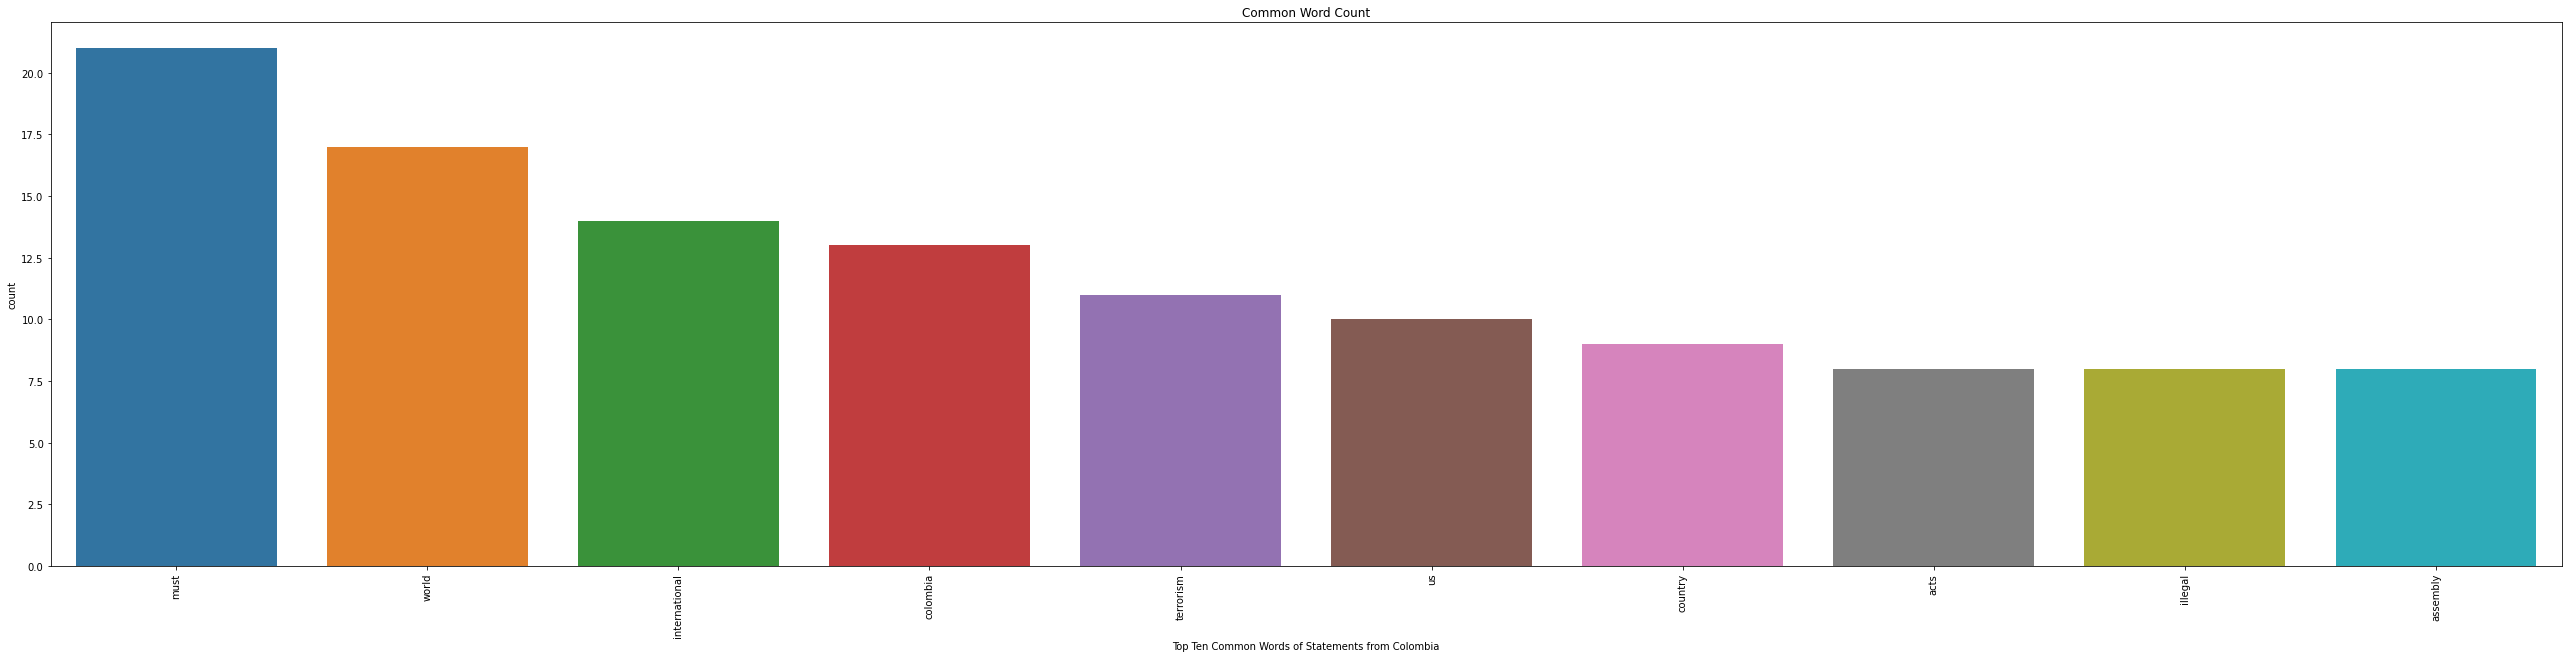

In [488]:
plt.figure(figsize=(45,10))
sns.countplot(clean_colombia_tokens, order=pd.Series(clean_colombia_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Colombia')
plt.title('Common Word Count')
plt.show()

In [489]:
df_brazilc['text'] = df_brazilc['text'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')

In [490]:
df_brazilc['text'] = df_brazilc.apply(lambda x: nltk.word_tokenize(x['text']), axis = 1)
df_brazilc.head()

,session,year,country,text,alpha-3_code,country_name
114,44,1989,BRA,"[﻿, mr, president, allow, me, to, congratulate...",BRA,Brazil
194,25,1970,BRA,"[mr, president, i, should, like, first, of, al...",BRA,Brazil
396,68,2013,BRA,"[i, would, first, like, to, briefly, express, ...",BRA,Brazil
457,40,1985,BRA,"[i, still, have, before, my, eyes, the, suffer...",BRA,Brazil
695,63,2008,BRA,"[it, is, my, great, pleasure, to, greet, my, d...",BRA,Brazil


In [491]:
df_brazilc['text'] = df_brazilc.apply(lambda y: no_stop_words(y['text']), axis=1)
df_brazilc['text']

114     [﻿, mr, president, allow, congratulate, excell...
194     [mr, president, like, first, congratulate, una...
396     [would, first, like, briefly, express, pleasur...
457     [still, eyes, suffering, mexico, undergone, la...
695     [great, pleasure, greet, dear, friend, mr, mig...
850     [﻿mr, president, may, congratulate, upon, elec...
1005    [behalf, brazilian, government, privilege, con...
1187    [congratulate, sir, election, presidency, gene...
1287    [mr, president, may, first, words, express, sa...
1391    [﻿please, accept, congratulations, sir, electi...
1564    [﻿once, woman, ’, voice, opening, general, deb...
1765    [﻿on, behalf, brazilian, delegation, would, li...
1968    [﻿, mr, president, tradition, offers, brazil, ...
2214    [﻿, mr, president, tradition, dating, back, ea...
2221    [great, honour, come, rostrum, speak, behalf, ...
2467    [﻿, behalf, government, brazil, gives, great, ...
2609    [gives, great, pleasure, make, use, common, la...
2736    [gener

In [492]:
for b in df_brazilc['text']:
    clean_brazil_tokens = b

In [493]:
Counter(clean_brazil_tokens).most_common(20)

[('must', 14),
 ('united', 13),
 ('nations', 12),
 ('international', 12),
 ('world', 11),
 ('brazil', 11),
 ('countries', 10),
 ('peace', 9),
 ('development', 9),
 ('terrorism', 9),
 ('—', 8),
 ('globalization', 8),
 ('peoples', 6),
 ('states', 6),
 ('solidarity', 5),
 ('new', 5),
 ('general', 5),
 ('act', 5),
 ('century', 5),
 ('state', 5)]

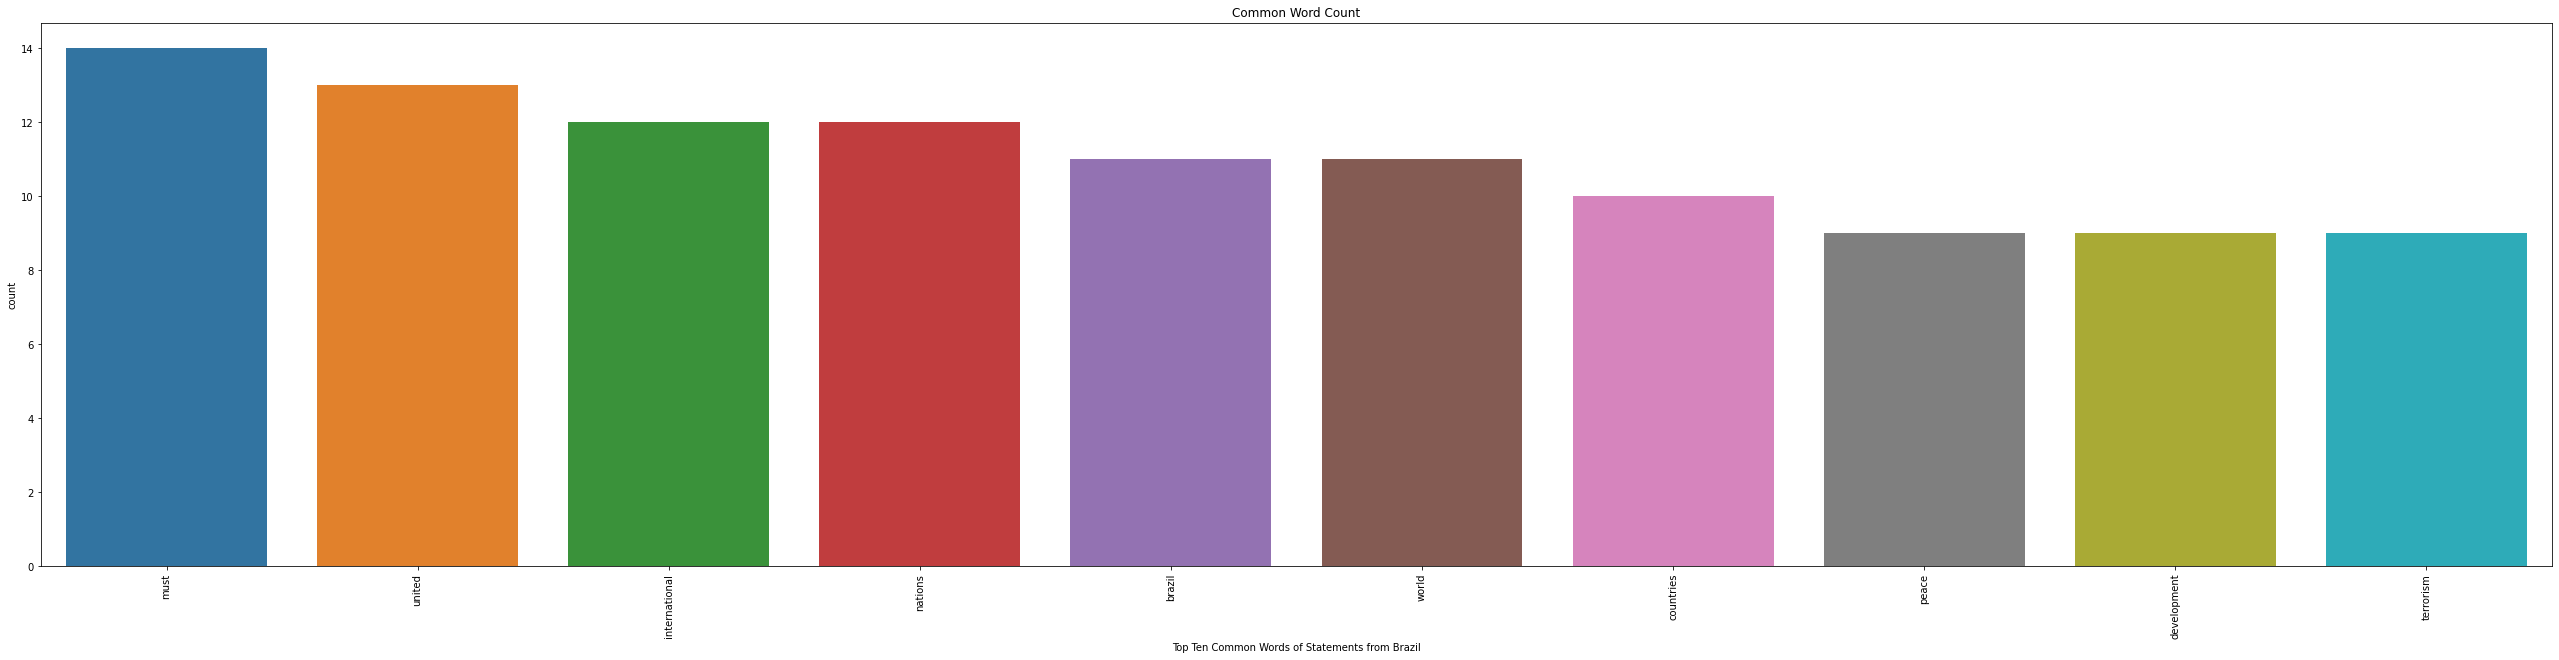

In [494]:
plt.figure(figsize=(45,10))
sns.countplot(clean_brazil_tokens, order=pd.Series(clean_brazil_tokens).value_counts().index[:10])
plt.xticks(rotation=90)
plt.xlabel('Top Ten Common Words of Statements from Brazil')
plt.title('Common Word Count')
plt.show()

From the plots obtained above we can observe that after removing the stopwords/ helping verbs from the texts from all the three countries the most commonly repeated meaningful words are "japan" from Japan's text and "must" from Colombia's and Brazil's text. The word "peace" from Japan's text, "assembly" from Colombia's text and "terrorism" from Brazil's text are least frequently repeated among the top 20 most commonly repeated words. Also the cleaned texts do not show the repeatitive pronounciations unlike the unclean texts. 

### <span style="color:magenta"> Q4. [20 pts] Lemmas across sessions
1. Select three UN sessions covered by the data.
1. Obtain the lemmas and their counts for all statements for a given session and select the top 10+ lemmas (your choice for how many to consider). 
 - Remove stop words, punctuations, and any other characters or words you deem necessary during this process.
1. Of the lemmas with counts above zero across all three sessions, select five and plot them and their counts across time. Make sure your plot is labeled and has a title. 
1. Describe the patterns you can see in the plot. Does it seem to indicate any changes in topics over time? Can you relate any of these trends to world events occurring at that time?

In [495]:
from nltk.corpus import stopwords
print(stopwords.words('english'))
df_final['text'] = df_final['text'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [496]:
session_one = df_final.text.iloc[60]
session_one
session_token_one = nltk.word_tokenize(session_one)

In [497]:
stopwords = set(stopwords.words('english'))
meaningful_session1 = []
for t in session_token_one:
    if not t.lower() in stopwords:
        meaningful_session1.append(t)
wordsent = ' '.join(meaningful_session1)
wordsent
print("Meaningful words from text one: ",wordsent)

Meaningful words from text one:  ﻿ bring greetings government people grenada delegation joins many eloquent expressions confidence trust reposed presidents great diplomatic interpersonal skills presides unparalleled confidence competence deliberations forty-fourth session general assembly additionally ray delegation places record admiration esteem former foreign minister argentina mr dante caputo outstanding conduct forty-third session united nations general assembly ray light burst forth international scene closing days forty-third session general assembly gives hope curtain continues rise assemblys forty-fourth session international peace goodwill sustained end nations increase trust one another feel safer end secure deliberations interactions secretary-general united nations ardent advocate peace extensive travels many geographical regions advanced peace process quiet effective skilful diplomacy left national leaders walk corridors power sail favourable wind blowing favourable tide 

In [498]:
session_two = df_final.text.iloc[100]
session_two
session_token_two = nltk.word_tokenize(session_two)

In [499]:
meaningful_session2 = []
for t in session_token_two:
    if not t.lower() in stopwords:
        meaningful_session2.append(t)
wordsent = ' '.join(meaningful_session2)
wordsent
print("Meaningful words from text one: ",wordsent)

Meaningful words from text one:  ﻿it gives great pleasure sir offer behalf pakistan delegation warm sincere felicitations election president ganeral assembly forty-fourth session unanimous election tribute well recognition important role played nigeria promoting international peace security progress relations two countries highly treasure always marked friendship understanding co-operation confident guide deliberations assembly distinction like express deep appreciation leadership provided predecessor excellency mr dante caputo presiding previous session general assembly like also pay special tribute secretary-general excellency mr javier perez de cuellar untiring efforts promote purposes principles united nations cause international peace leadership united nations emerged credible effective instrument promotion maintenance peace around world pakistan continue extend full co-operation consolidation international peace security progress honoured bring body greetings people government pa

In [500]:
session_three = df_final.text.iloc[160]
session_three
session_token_three = nltk.word_tokenize(session_three)

In [501]:
meaningful_session3 = []
for t in session_token_three:
    if not t.lower() in stopwords:
        meaningful_session3.append(t)
wordsent = ' '.join(meaningful_session3)
wordsent
print("Meaningful words from text one: ",wordsent)

Meaningful words from text one:  mr president instead offering congratulations preceding speakers done wish thank behalf delegation thank sought accepted election presidency historic session general assembly bring high office rare combination experience qualifications distinguished diplomat country also distinguished international civil servant eminent scholar also practitioner craft government country background mr president delegation confident management affairs principled practical expeditious hit expedient year celebrate twenty -- fifth anniversary founding united nations even celebrate occasion owe future also make realistic appraisal strengths weaknesses organization prevails substantial body opinion maintains performance united nations fallen far short expectations described organization facing crisis confidence others said united nations afflicted creeping irrelevance one thoughtful critic recently written united nations today probably enjoys less confidence part members publi

In [502]:
from collections import Counter
most_common1 = Counter(meaningful_session1).most_common(20)
session1_df = pd.DataFrame(most_common1)

session1_df_named = session1_df.rename(columns = {0:"Word",1:"Count"})
session1_df_named.head()

,Word,Count
0,nations,29
1,united,26
2,peace,25
3,international,19
4,community,14


In [503]:
most_common2 = Counter(meaningful_session2).most_common(20)
session2_df = pd.DataFrame(most_common2)

session2_df_named = session2_df.rename(columns = {0:"Word",1:"Count"})
session2_df_named.head()

,Word,Count
0,people,23
1,international,22
2,pakistan,21
3,countries,21
4,nations,19


In [504]:
most_common3 = Counter(meaningful_session3).most_common(20)
session3_df = pd.DataFrame(most_common3)

session3_df_named = session3_df.rename(columns = {0:"Word",1:"Count"})
session3_df_named.head()

,Word,Count
0,nations,45
1,united,39
2,general,13
3,one,13
4,assembly,12


In [505]:
full_session1 = session1_df_named.merge(session2_df_named, on= "Word", how = "outer")
full_session1.head()

,Word,Count_x,Count_y
0,nations,29.0,19.0
1,united,26.0,16.0
2,peace,25.0,12.0
3,international,19.0,22.0
4,community,14.0,NaN


In [506]:
full_session2 = full_session1.merge(session3_df_named, on= "Word", how = "outer")
full_session2.head()

,Word,Count_x,Count_y,Count
0,nations,29.0,19.0,45.0
1,united,26.0,16.0,39.0
2,peace,25.0,12.0,NaN
3,international,19.0,22.0,NaN
4,community,14.0,NaN,NaN


In [507]:
#remove NaN
full_session3 = full_session2.replace(np.NaN, 0)
full_session = full_session3.rename(columns = {"Count_x":"Session 60","Count_y": "Session 100","Count": "Session 160" })
full_session
top_five = full_session.set_index('Word').head(5)
top_five

,Session 60,Session 100,Session 160
Word,,,
nations,29.0,19.0,45.0
united,26.0,16.0,39.0
peace,25.0,12.0,0.0
international,19.0,22.0,0.0
community,14.0,0.0,0.0


In [508]:
session_plot_df = top_five.transpose()
session_plot_df

Word,nations,united,peace,international,community
Session 60,29.0,26.0,25.0,19.0,14.0
Session 100,19.0,16.0,12.0,22.0,0.0
Session 160,45.0,39.0,0.0,0.0,0.0


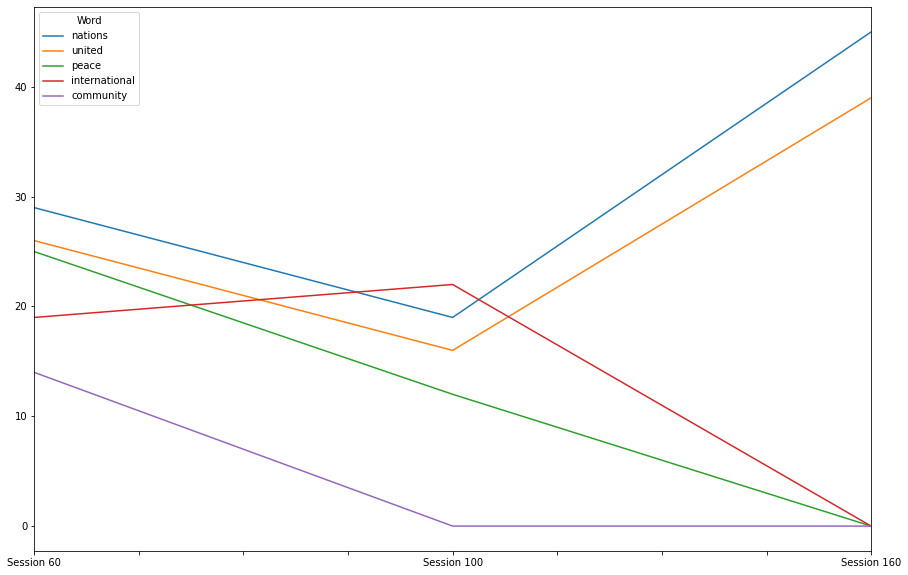

In [509]:
session_plot_df.plot(kind = 'line',figsize = (15,10))

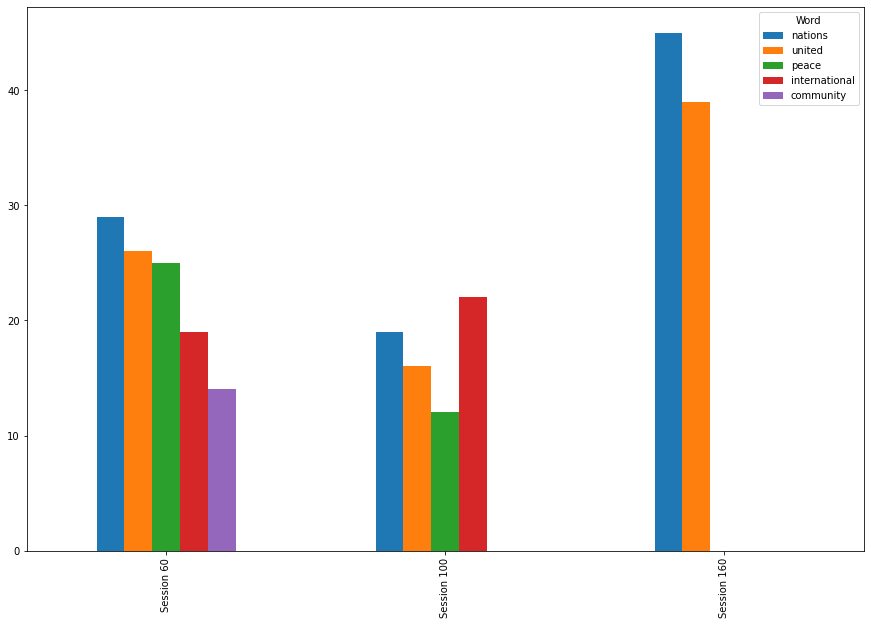

In [510]:
session_plot_df.plot(kind = 'bar',figsize = (15,10))

From the above line graph and boxplot it can be analysed that Session 60 has all the five words in good frequency, Session 100 has all the words except "community" in average frequency and Session 160 has the highest frequency of the word "nations" and united" but also lowest/absence of the words "community", "international" and "peace".

### <span style="color:magenta"> Bonus. [5 pts] Similarity using GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations of words that's conceptually similar to, but technically different from, Word2Vec. Use gensim to load a GloVe model, one way to do this is by importing and using gensim.downloader (https://radimrehurek.com/gensim/downloader.html). See available options for GloVe models here: https://github.com/RaRe-Technologies/gensim-data#models. Even the smallest GloVe model should suffice for our purposes.
1. Choose 5 words related to the UN and its mission (https://www.un.org/en/sections/what-we-do/).
1. What are the top-10 similar words of each? Do you find anything odd or interesting? Please explain.
1. What do the top-10 most similar words indicate about the searched word, its definition, or what it implies?
    
Make a good choice in terms of how much time you spend on a five point bonus question. It may not be worth hours of effort if it's too demanding. 😊

In [511]:
# put your code here

Worked on the notebook with Tanvi Shah and David Josue Molina